<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

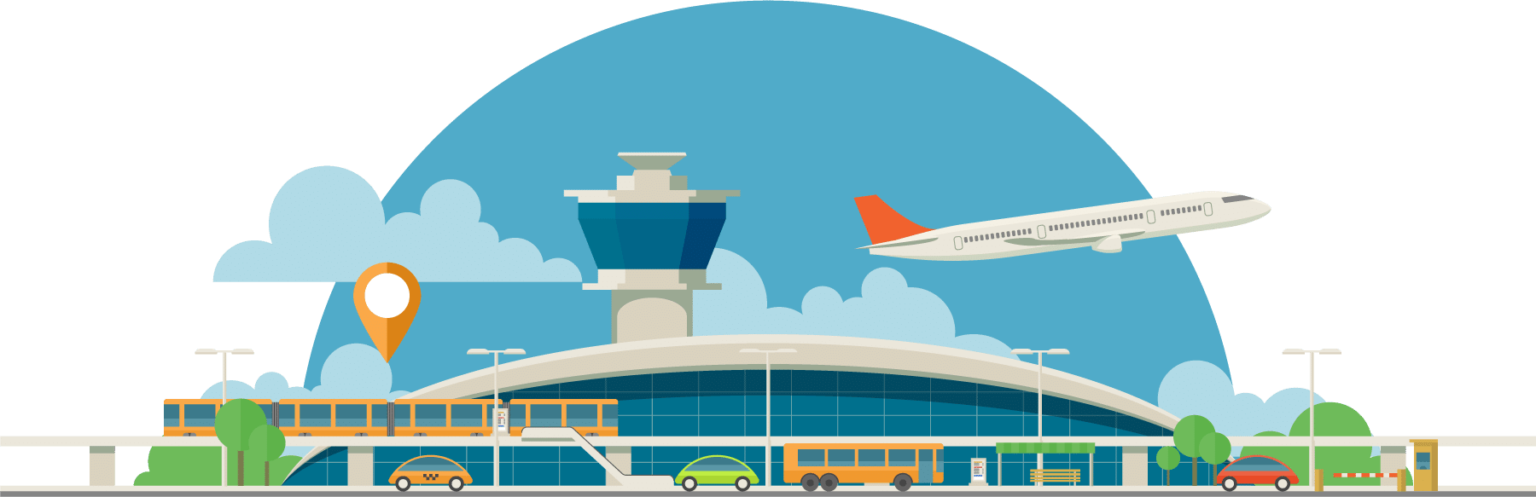

In [4]:
# установка всех библиотек, необходимых для выполнения ДЗ

%pip install catboost
%pip install mlxtend --upgrade
%pip install optuna
%pip install lime
%pip install shap
%pip install missingno
%pip install psycopg2-binary
%pip install xgboost
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [4]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-01-23 11:38:42--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3,5K) [application/x-x509-ca-cert]
Saving to: ‘/Users/akovel/.postgresql/root.crt’

/Users/akovel/.post 100%[===================>]   3,50K  --.-KB/s    in 0s      

2025-01-23 11:38:42 (3,33 GB/s) - ‘/Users/akovel/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

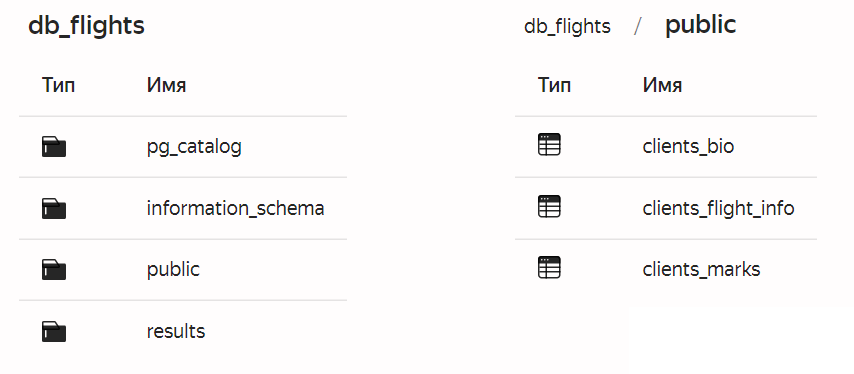



In [3]:
connection_params = {
    'host': 'rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
    'port': 6432,
    'dbname': 'db_flights',
    'user': 'mlhs_student',
    'password': 'mlhs_student',
    'sslmode': 'verify-full',
    'target_session_attrs': 'read-write'
}

In [4]:
sql_query = """
SELECT * 
FROM clients_bio 
LIMIT 3;
"""
with psycopg2.connect(**connection_params) as conn:
    clients_bio = pd.read_sql_query(sql_query, conn)
    print(clients_bio)

   id  gender   age
0   1    Male  48.0
1   2  Female  35.0
2   3    Male  41.0


/var/folders/zz/gp2ff22x0kd0hxvd61_3_hc00000gn/T/ipykernel_54608/3260224776.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  clients_bio = pd.read_sql_query(sql_query, conn)


In [10]:
sql_query = """
SELECT * 
FROM clients_flight_info
LIMIT 3;
"""
with psycopg2.connect(**connection_params) as conn:
    clients_flight_info = pd.read_sql_query(sql_query, conn)
    print(clients_flight_info)

   id      Customer Type   Type of Travel     class Flight Distance  \
0   1  disloyal Customer  Business travel  Business           821.0   
1   2     Loyal Customer  Business travel  Business           821.0   
2   3     Loyal Customer  Business travel  Business           853.0   

  Departure Delay in Minutes Arrival Delay in Minutes  
0                        2.0                      5.0  
1                       26.0                     39.0  
2                        0.0                      0.0  


/var/folders/zz/gp2ff22x0kd0hxvd61_3_hc00000gn/T/ipykernel_57526/2381520238.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  clients_flight_info = pd.read_sql_query(sql_query, conn)


In [11]:
sql_query = """
SELECT * 
FROM clients_marks
LIMIT 3;
"""
with psycopg2.connect(**connection_params) as conn:
    clients_flight_info = pd.read_sql_query(sql_query, conn)
    print(clients_flight_info)

   id Inflight wifi service Departure/Arrival time convenient  \
0   1                   3.0                               3.0   
1   2                   2.0                               2.0   
2   3                   4.0                               4.0   

  Ease of Online booking Gate location Food and drink Online boarding  \
0                    3.0           3.0            5.0             3.0   
1                    2.0           2.0            3.0             5.0   
2                    4.0           4.0            5.0             5.0   

  Seat comfort Inflight entertainment On-board service Leg room service  \
0          5.0                    5.0              3.0              2.0   
1          4.0                    5.0              5.0              5.0   
2          5.0                    3.0              3.0              3.0   

  Baggage handling Checkin service Inflight service cleanliness  \
0              5.0             4.0              5.0         5.0   
1          

/var/folders/zz/gp2ff22x0kd0hxvd61_3_hc00000gn/T/ipykernel_57526/1640514424.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  clients_flight_info = pd.read_sql_query(sql_query, conn)


In [25]:
sql_query = """
SELECT     
    clients_bio.id, 
    clients_bio.gender, 
    clients_bio.age, 
    clients_flight_info."Customer Type", 
    clients_flight_info."Type of Travel", 
    clients_flight_info.class, 
    clients_flight_info."Flight Distance", 
    clients_flight_info."Departure Delay in Minutes", 
    clients_flight_info."Arrival Delay in Minutes", 
    clients_marks."Inflight wifi service", 
    clients_marks."Departure/Arrival time convenient", 
    clients_marks."Ease of Online booking", 
    clients_marks."Gate location", 
    clients_marks."Food and drink", 
    clients_marks."Online boarding", 
    clients_marks."Seat comfort", 
    clients_marks."Inflight entertainment", 
    clients_marks."On-board service", 
    clients_marks."Leg room service", 
    clients_marks."Baggage handling", 
    clients_marks."Checkin service", 
    clients_marks."Inflight service", 
    clients_marks.cleanliness, 
    clients_marks.satisfaction
FROM clients_bio
JOIN clients_flight_info ON clients_bio.id = clients_flight_info.id
JOIN clients_marks ON clients_bio.id = clients_marks.id
"""
with psycopg2.connect(**connection_params) as conn:
    df = pd.read_sql_query(sql_query, conn)
df.set_index('id', inplace=True)
print(df)

/var/folders/zz/gp2ff22x0kd0hxvd61_3_hc00000gn/T/ipykernel_54608/1499168241.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


        gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   
129868    Male  47.0     Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   

       Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id         

In [26]:
df_backup = df.copy()

In [97]:
df = df_backup.copy()

In [98]:
df.columns


Index(['gender', 'age', 'Customer Type', 'Type of Travel', 'class',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness', 'satisfaction'],
      dtype='object')

In [99]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

In [101]:
df.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied


In [102]:
numeric_columns = [
    'age',
    'cleanliness',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'cleanliness',
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink'
]

In [103]:
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [104]:
missing_values = df.isnull().sum()
print("Пропуски в столбцах:")
print(missing_values[missing_values > 0])


Пропуски в столбцах:
age                                  315
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
dtype: int64


In [105]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

In [106]:
for col in numeric_columns:
    outliers = detect_outliers_iqr(df[col])
    print(f"\nВыбросы в столбце '{col}':")
    print(df[outliers])


Выбросы в столбце 'age':
        gender    age      Customer Type   Type of Travel     class  \
id                                                                    
1542      Male   96.0     Loyal Customer  Business travel  Business   
5797      Male  177.0  disloyal Customer  Business travel  Business   
5994    Female  147.0     Loyal Customer  Business travel  Business   
7171    Female  100.0  disloyal Customer  Business travel       Eco   
13336     Male  441.0     Loyal Customer  Business travel  Business   
...        ...    ...                ...              ...       ...   
117394    Male  231.0     Loyal Customer  Business travel  Business   
118455  Female  129.0     Loyal Customer  Business travel  Business   
125464  Female  100.0     Loyal Customer  Business travel  Business   
125575    Male   93.0     Loyal Customer  Personal Travel       Eco   
128347    Male  100.0     Loyal Customer  Business travel  Business   

        Flight Distance  Departure Delay in Minute

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Figure size 1200x600 with 0 Axes>

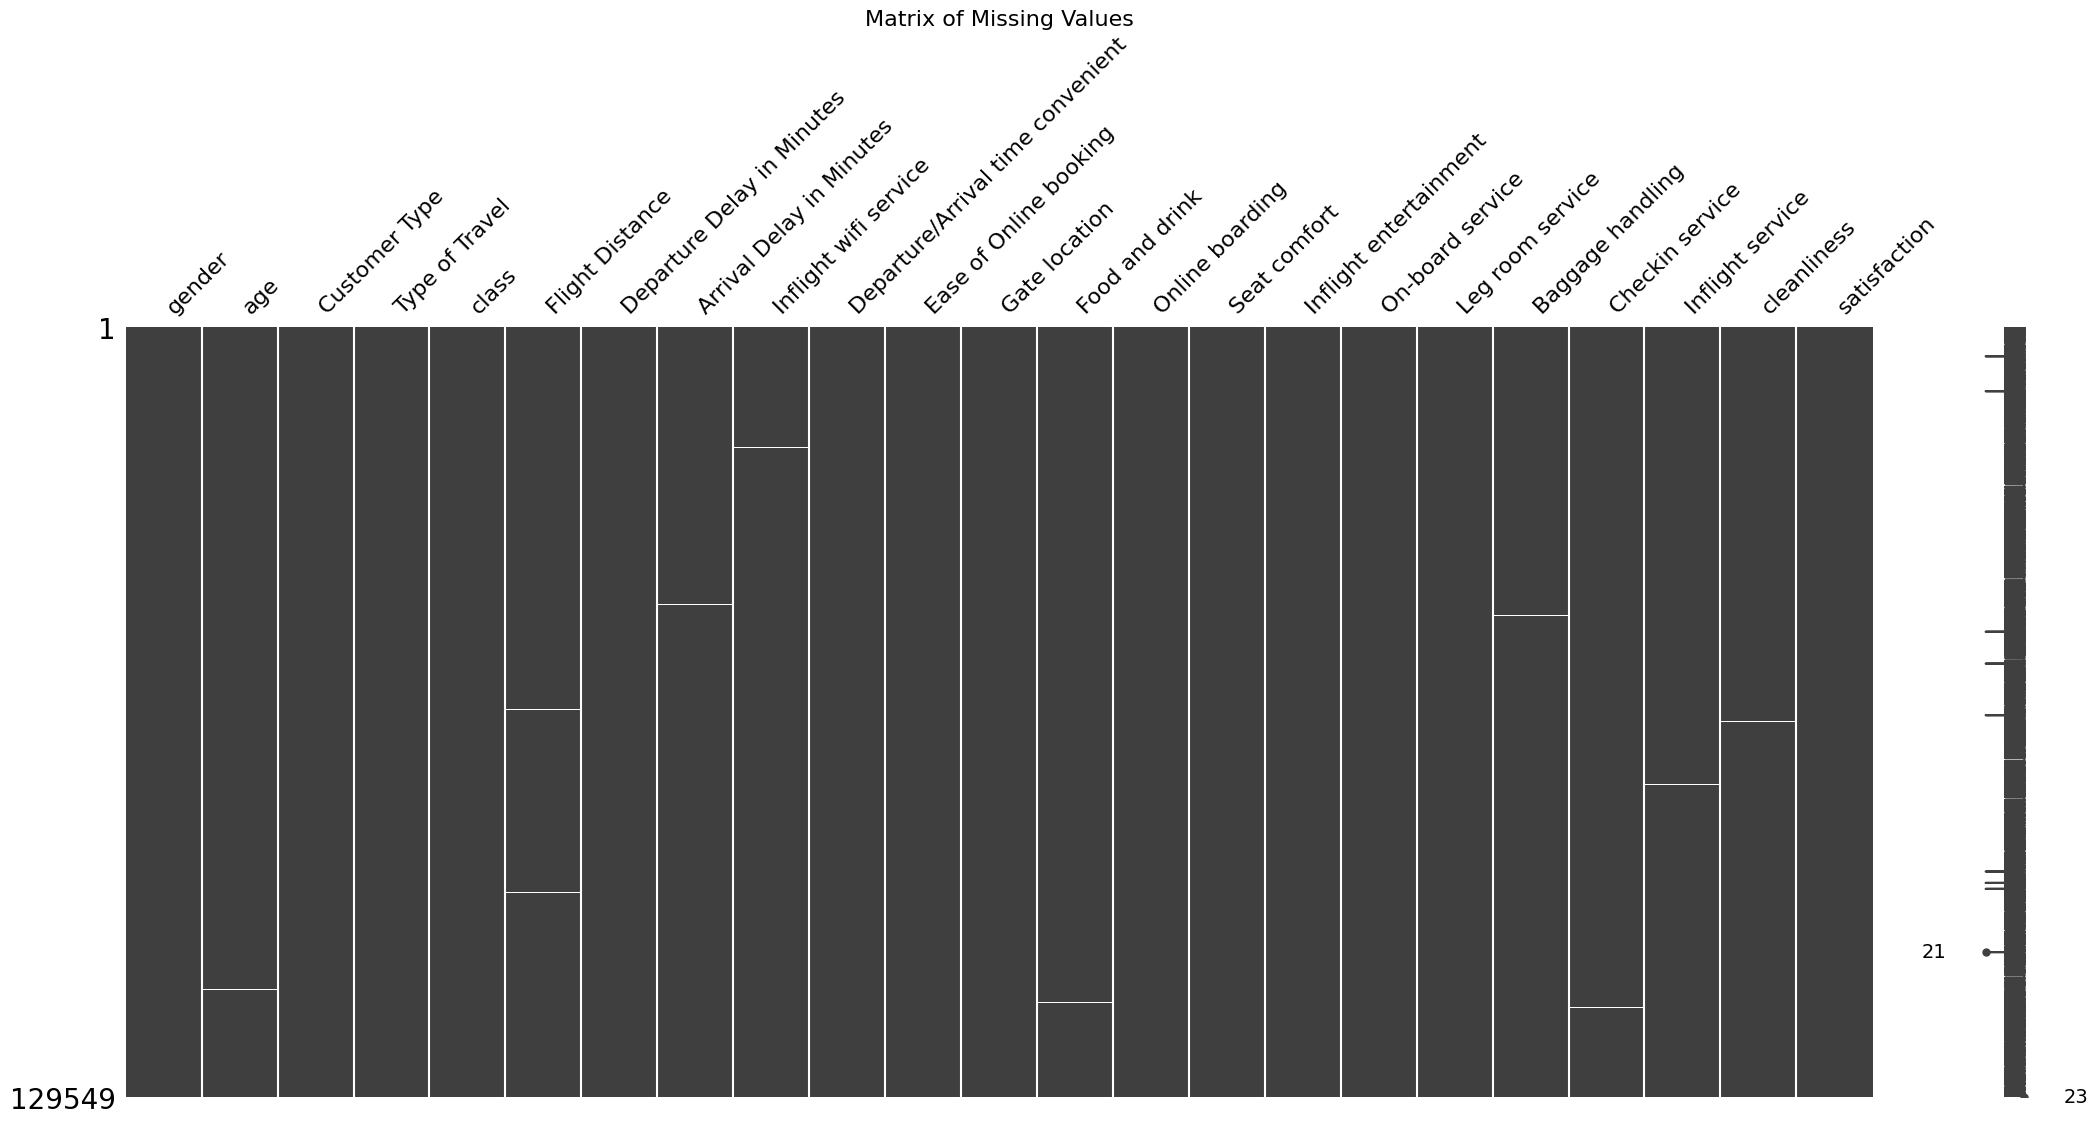

In [107]:
import missingno as msno

plt.figure(figsize=(12, 6))
msno.matrix(df)
plt.title('Matrix of Missing Values', fontsize=16)
plt.show()

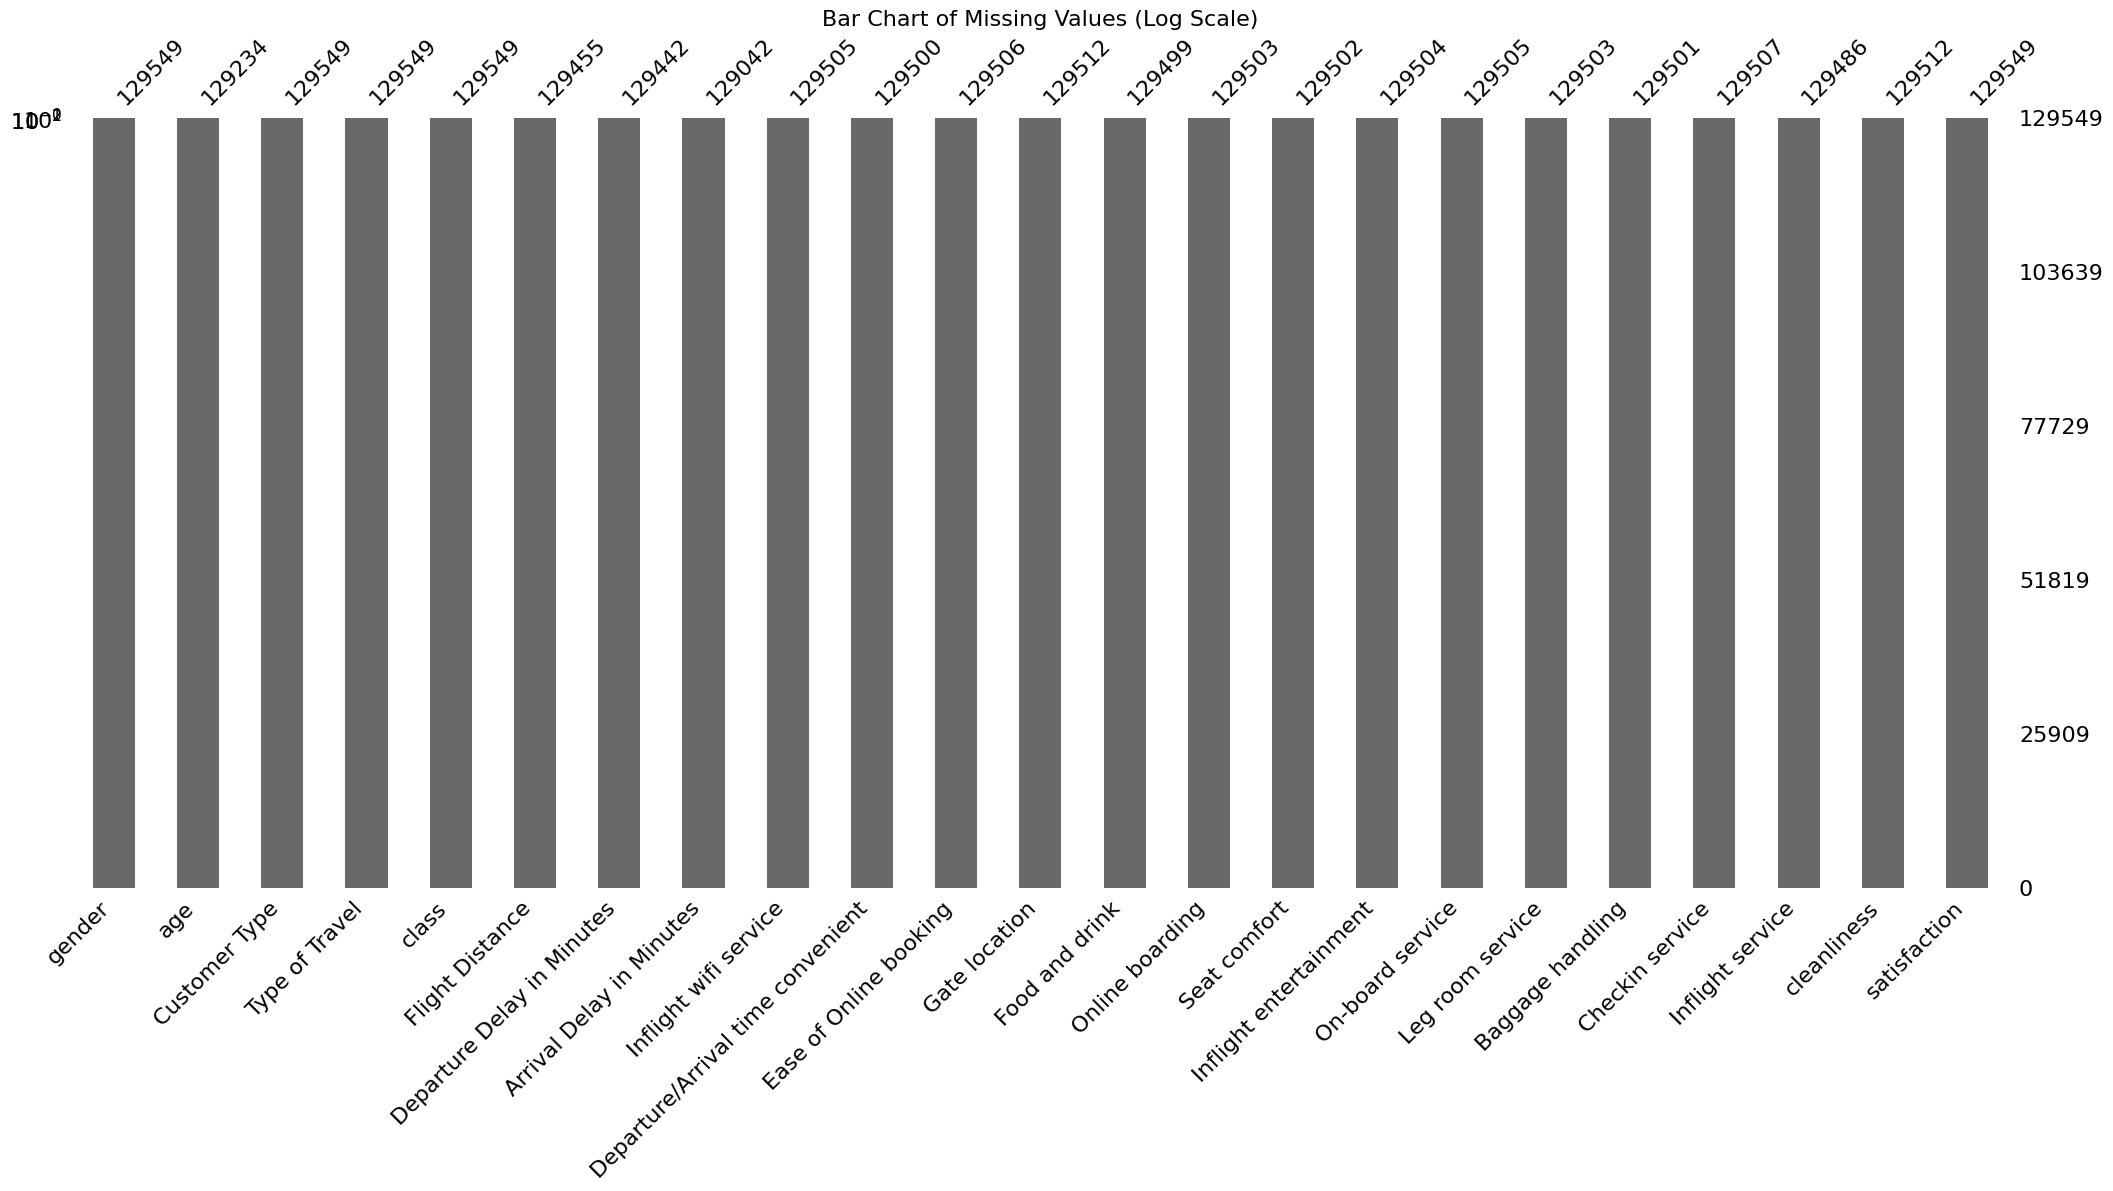

In [108]:
plt.figure(figsize=(12, 6))
msno.bar(df)
plt.yscale('log') 
plt.title('Bar Chart of Missing Values (Log Scale)', fontsize=16)
plt.show()

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [109]:
df_train = df[df.satisfaction != '-']
df_train

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129831,Female,28.0,Loyal Customer,Personal Travel,Eco,447.0,23.0,16.0,1.0,3.0,...,1.0,3.0,3.0,1.0,1.0,4.0,1.0,5.0,3.0,neutral or dissatisfied
129837,Male,66.0,Loyal Customer,Personal Travel,Eco,337.0,199.0,213.0,2.0,4.0,...,5.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,5.0,neutral or dissatisfied
129838,Female,59.0,Loyal Customer,Personal Travel,Eco,308.0,32.0,24.0,3.0,5.0,...,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,neutral or dissatisfied


In [110]:
assert df_train.shape == (103_644, 23)

In [111]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
55,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129750,Male,38.0,Loyal Customer,Business travel,Eco,337.0,92.0,82.0,4.0,3.0,...,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,4.0
129771,Male,16.0,Loyal Customer,Personal Travel,Eco,308.0,2.0,0.0,3.0,4.0,...,1.0,3.0,5.0,1.0,4.0,2.0,5.0,5.0,4.0,1.0
129798,Female,43.0,Loyal Customer,Personal Travel,Eco,308.0,0.0,0.0,2.0,4.0,...,3.0,5.0,5.0,4.0,4.0,2.0,4.0,4.0,4.0,5.0


In [112]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [113]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [114]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [115]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

print("Пропуски в числовых столбцах перед заполнением:")
print(X_train[numeric_cols].isnull().sum())
print("\nПропуски в категориальных столбцах перед заполнением:")
print(X_train[categorical_cols].isnull().sum())


Пропуски в числовых столбцах перед заполнением:
age                                  185
Flight Distance                       54
Departure Delay in Minutes            61
Arrival Delay in Minutes             294
Inflight wifi service                 23
Departure/Arrival time convenient     28
Ease of Online booking                24
Gate location                         19
Food and drink                        22
Online boarding                       23
Seat comfort                          23
Inflight entertainment                30
On-board service                      23
Leg room service                      22
Baggage handling                      21
Checkin service                       22
Inflight service                      30
cleanliness                           21
dtype: int64

Пропуски в категориальных столбцах перед заполнением:
gender            0
Customer Type     0
Type of Travel    0
class             0
dtype: int64


In [117]:
for col in categorical_cols:
    mode_value = X_train[col].mode()[0]  
    X_train[col]= X_train[col].fillna(mode_value) 
    X_train[col] = X_train[col].apply(lambda x: mode_value if x == 'nan' else x)

for col in numeric_cols:
    mode_value = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_value)

In [118]:
print("\nПропуски в числовых столбцах после заполнения:")
print(X_train[numeric_cols].isnull().sum())
print("\nПропуски в категориальных столбцах после заполнения:")
print(X_train[categorical_cols].isnull().sum())


Пропуски в числовых столбцах после заполнения:
age                                  0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

Пропуски в категориальных столбцах после заполнения:
gender            0
Customer Type     0
Type of Travel    0
class             0
dtype: int64


### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [119]:
for col in X_train.select_dtypes(include=['object']).columns:
    top_value = X_train[col].mode()[0]
    top_count = X_train[col].value_counts().iloc[0]
    unique_values = X_train[col].unique()
    
    print(f"Для признака '{col}' наиболее часто встречающееся значение: '{top_value}' ({top_count} раз).")
    print(f"Всего уникальных значений: {unique_values}.\n")


Для признака 'gender' наиболее часто встречающееся значение: 'Female' (36816 раз).
Всего уникальных значений: ['Female' 'Male'].

Для признака 'Customer Type' наиболее часто встречающееся значение: 'Loyal Customer' (59406 раз).
Всего уникальных значений: ['disloyal Customer' 'Loyal Customer'].

Для признака 'Type of Travel' наиболее часто встречающееся значение: 'Business travel' (50054 раз).
Всего уникальных значений: ['Business travel' 'Personal Travel'].

Для признака 'class' наиболее часто встречающееся значение: 'Business' (34793 раз).
Всего уникальных значений: ['Business' 'Eco' 'Eco Plus'].



In [120]:
for col in X_train.select_dtypes(include=['float64', 'int64']).columns:
    mean_value = X_train[col].mean()
    median_value = X_train[col].median()
    std_dev = X_train[col].std()
    min_value = X_train[col].min()
    max_value = X_train[col].max()
    
    print(f"Для числового признака '{col}' среднее значение: {mean_value:.2f}, медиана: {median_value:.2f}, ")
    print(f"стандартное отклонение: {std_dev:.2f}, минимальное значение: {min_value}, максимальное значение: {max_value}.")

Для числового признака 'age' среднее значение: 40.10, медиана: 40.00, 
стандартное отклонение: 20.66, минимальное значение: 0.0, максимальное значение: 544.0.
Для числового признака 'Flight Distance' среднее значение: 1329.02, медиана: 844.00, 
стандартное отклонение: 4764.37, минимальное значение: 0.0, максимальное значение: 379620.0.
Для числового признака 'Departure Delay in Minutes' среднее значение: 15.86, медиана: 0.00, 
стандартное отклонение: 70.86, минимальное значение: 0.0, максимальное значение: 9282.0.
Для числового признака 'Arrival Delay in Minutes' среднее значение: 16.65, медиана: 0.00, 
стандартное отклонение: 97.99, минимальное значение: 0.0, максимальное значение: 11760.0.
Для числового признака 'Inflight wifi service' среднее значение: 2.73, медиана: 3.00, 
стандартное отклонение: 1.36, минимальное значение: 0.0, максимальное значение: 45.0.
Для числового признака 'Departure/Arrival time convenient' среднее значение: 3.07, медиана: 3.00, 
стандартное отклонение: 1.5

В категориальных почти всё балдежно, есть небольшие перекосы в данных, но в целом ок.

В числовых данных много чего распределено далеко не нормально, но в целом тоже сойдет

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [121]:
for col in numeric_cols:
    quantile_996 = X_train[col].quantile(0.996)
    
    X_train = X_train[X_train[col] <= quantile_996]
    y_train = y_train[X_train.index] 

    X_val = X_val[X_val[col] <= quantile_996]
    y_val = y_val[X_val.index]  

print(f"Размер обучающего набора данных после удаления выбросов: {X_train.shape}")
print(f"Размер валидационного набора данных после удаления выбросов: {X_val.shape}")

Размер обучающего набора данных после удаления выбросов: (71175, 22)
Размер валидационного набора данных после удаления выбросов: (30105, 22)


In [122]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [123]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [124]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [152]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    plt.figure(figsize=(10, 50))
    for i, col in enumerate(cols):
        plt.subplot(len(cols), 1, i + 1)
        sns.countplot(data=df, x=col, hue=y, palette='viridis')
        plt.title(f'Countplot for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()



In [143]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    plt.figure(figsize=(15, 6))
    for i, col in enumerate(cols):
        plt.subplot(2, len(cols), i + 1)
        sns.histplot(data=df, x=col, hue=y, kde=True, palette='viridis', bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        
        plt.subplot(2, len(cols), len(cols) + i + 1)
        sns.boxplot(data=df, x=col, hue=y, palette='viridis')
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.ylabel('Values')
    plt.tight_layout()
    plt.show()


In [144]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(cols):
        plt.subplot(1, len(cols), i + 1)
        sns.countplot(data=df, x=col, hue=y, palette='viridis')
        plt.title(f'Countplot for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

Отрисовка.

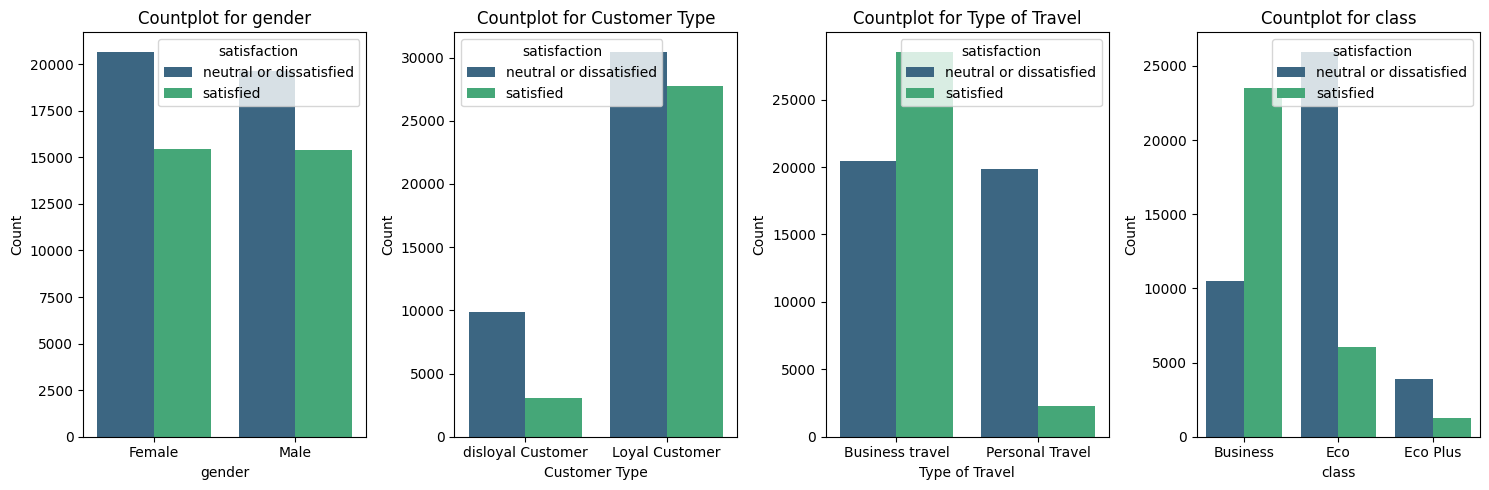

In [145]:
plot_categorical(categorical_cols, X_train, y_train)

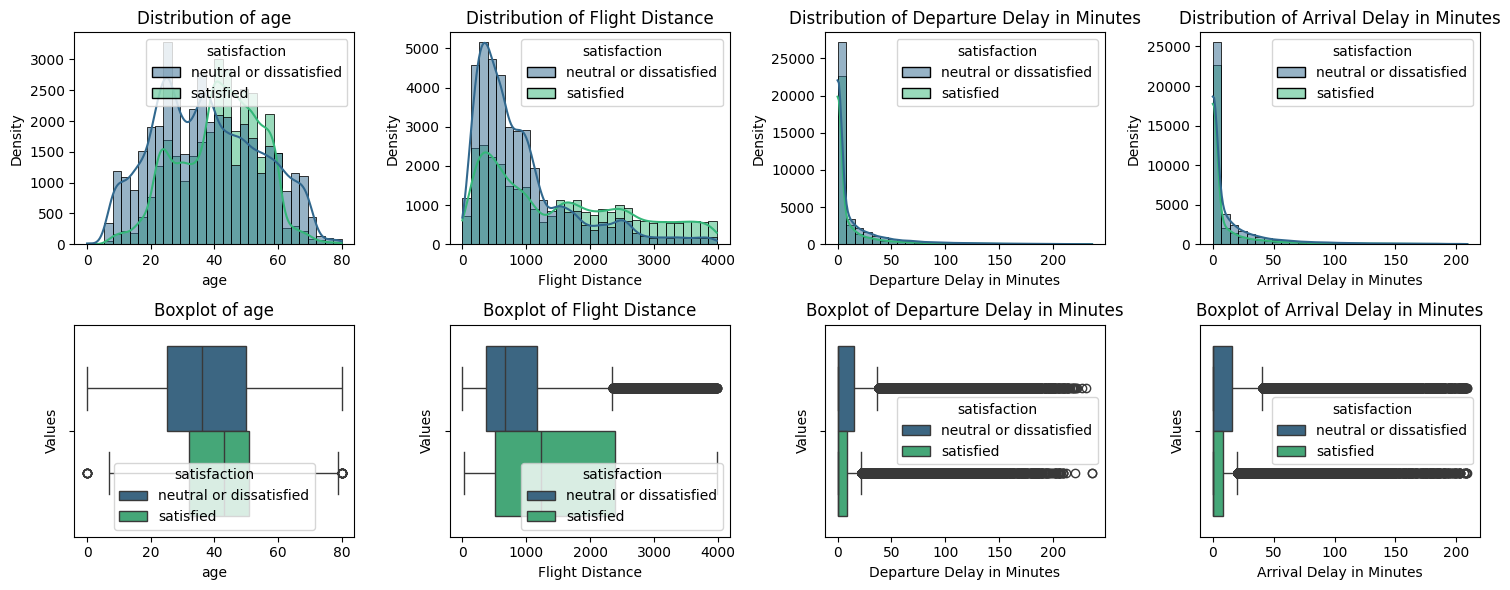

In [146]:
plot_continuous(continuous_cols, X_train, y_train)

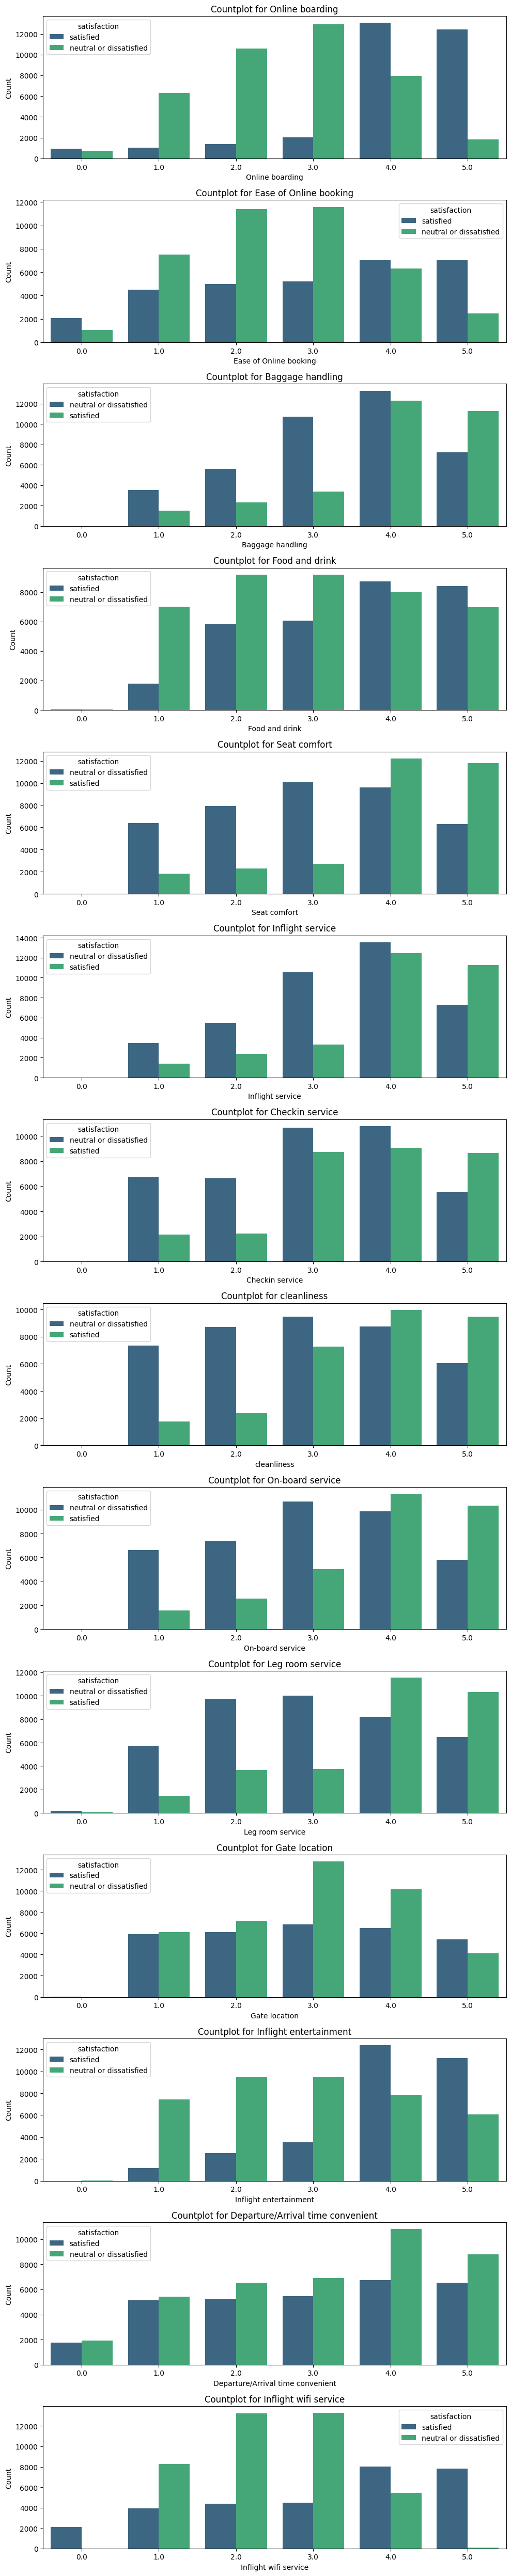

In [153]:
plot_ordinal(ordinal_cols, X_train, y_train)

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

### Распределены неравномерно
1. Тип мест. Там бизнес эко плюс
2. Те кто катался по приколу, не сказать, чтобы доволен. От тех кто катался по коммандировке
3. Женщины недовольны больше (думайте)
4. Если человек нормальный (лояльный), то отношение у него в целом ок. Буйные так себе реагируют
5. После 40 люди больше довольные, чем недовольны
6. Чем дальше летят, тем больше удовольствия

### континуальные признаки
Те которые изобразили

### сбалансированы ли классы

не все

### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [ ]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [154]:
import numpy as np

X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes'])

X_val['Departure Delay in Minutes'] = np.log1p(X_val['Departure Delay in Minutes'])
X_val['Arrival Delay in Minutes'] = np.log1p(X_val['Arrival Delay in Minutes'])

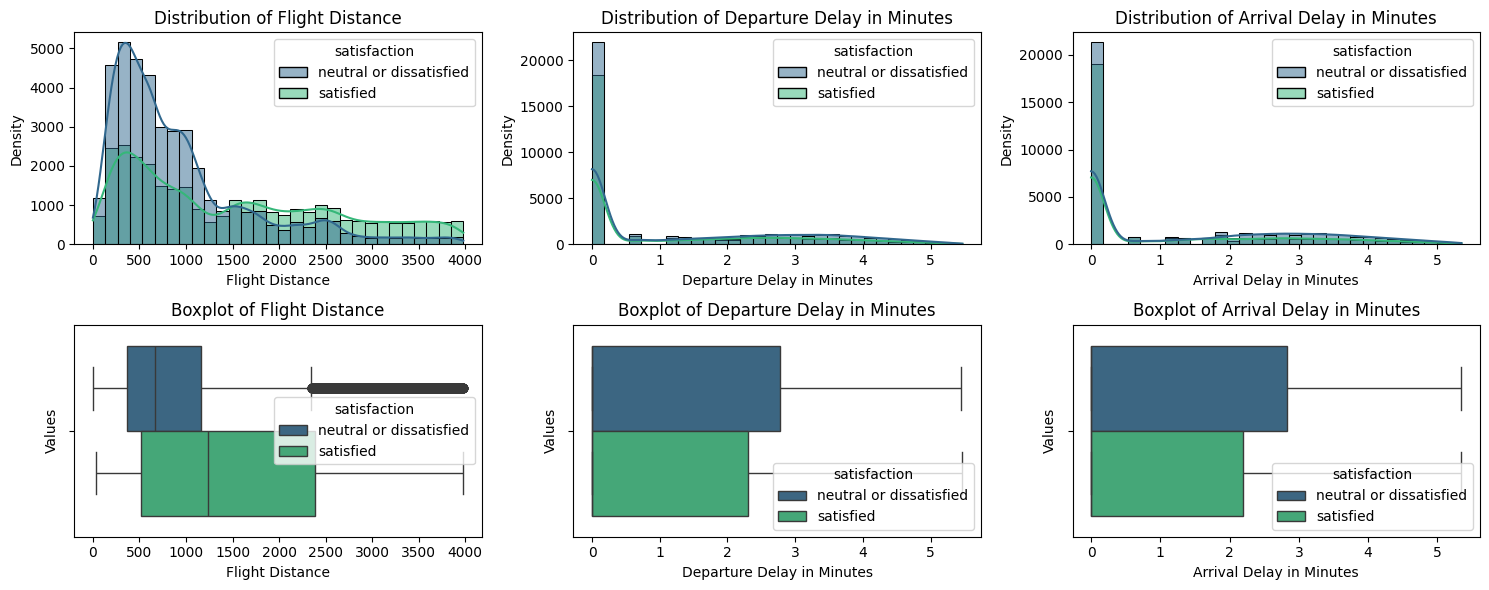

In [155]:
continuous_columns = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

plot_continuous(continuous_columns, X_train, y_train)

Построение.

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

<Figure size 1000x800 with 0 Axes>

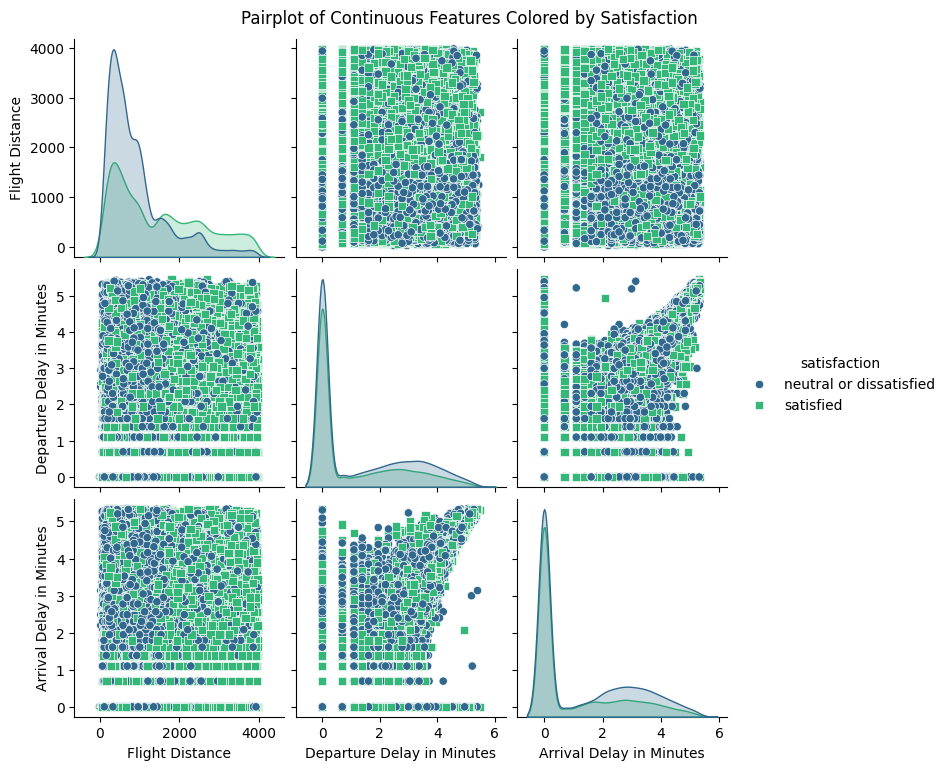

In [157]:
pairplot_data = pd.concat([X_train[continuous_columns], y_train], axis=1)
plt.figure(figsize=(10, 8))
sns.pairplot(pairplot_data, hue='satisfaction', palette='viridis', markers=['o', 's'])
plt.suptitle('Pairplot of Continuous Features Colored by Satisfaction', y=1.02)
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [158]:
y_train_encoded = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_val_encoded = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

In [159]:
X_train_encoded = pd.get_dummies(X_train, columns=X_train.select_dtypes(include=['object']).columns, drop_first=True)
X_val_encoded = pd.get_dummies(X_val, columns=X_val.select_dtypes(include=['object']).columns, drop_first=True)

X_train_encoded, X_val_encoded = X_train_encoded.align(X_val_encoded, join='left', axis=1, fill_value=0)

In [160]:
print(f"Размеры X_train_encoded: {X_train_encoded.shape}")
print(f"Размеры X_val_encoded: {X_val_encoded.shape}")
print(f"Размеры y_train_encoded: {y_train_encoded.shape}")
print(f"Размеры y_val_encoded: {y_val_encoded.shape}")

Размеры X_train_encoded: (71175, 23)
Размеры X_val_encoded: (30105, 23)
Размеры y_train_encoded: (71175,)
Размеры y_val_encoded: (30105,)


### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [161]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train_encoded, y_train_encoded)

y_val_pred = decision_tree.predict(X_val_encoded)

accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f'Accuracy on validation set: {accuracy:.4f}')

Accuracy on validation set: 0.9436


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [165]:
# Ваш код ниже — дополните его
from sklearn.metrics import make_scorer

error_dt, bias_dt, var_dt = bias_variance_decomp(
    decision_tree,
    X_train_encoded.values,
    y_train_encoded.values,
    X_val_encoded.values,
    y_val_encoded.values,
    loss='0-1_loss',
    random_seed=42
)

print(f'Error: {error_dt:.4f}')
print(f'Bias: {bias_dt:.4f}')
print(f'Variance: {var_dt:.4f}')

Error: 0.0615
Bias: 0.0401
Variance: 0.0458


### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [166]:
tree_depth = decision_tree.get_depth()
n_leaves = decision_tree.get_n_leaves()

print(f'Глубина дерева: {tree_depth}')
print(f'Количество листьев: {n_leaves}')

Глубина дерева: 34
Количество листьев: 2024


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

/var/folders/zz/gp2ff22x0kd0hxvd61_3_hc00000gn/T/ipykernel_54608/3154110998.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


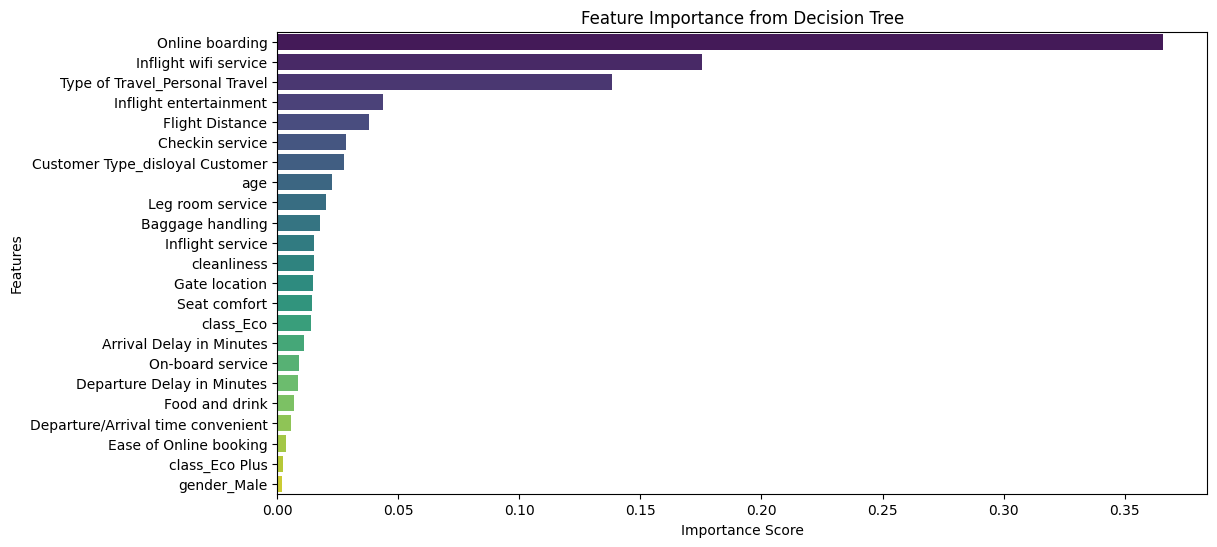

Наиболее информативные признаки:
                            Feature  Importance
9                   Online boarding    0.365785
4             Inflight wifi service    0.175434
20   Type of Travel_Personal Travel    0.138145
11           Inflight entertainment    0.043758
1                   Flight Distance    0.038032
15                  Checkin service    0.028423
19  Customer Type_disloyal Customer    0.027414
0                               age    0.022480
13                 Leg room service    0.020116
14                 Baggage handling    0.017627


In [167]:
importances = decision_tree.feature_importances_

feature_names = X_train_encoded.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

top_features = importance_df.head(10)
print("Наиболее информативные признаки:")
print(top_features)

1. Есть онлайн выбор
2. И wifi
3. И тип полет бизнес

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [168]:
selected_features = ['Online boarding', 'Inflight wifi service']

X_train_selected = X_train_encoded[selected_features]
X_val_selected = X_val_encoded[selected_features]

decision_tree_depth_5 = DecisionTreeClassifier(max_depth=5)
decision_tree_depth_5.fit(X_train_selected, y_train_encoded)

y_val_pred_depth_5 = decision_tree_depth_5.predict(X_val_selected)

accuracy_depth_5 = accuracy_score(y_val_encoded, y_val_pred_depth_5)
print(f'Accuracy on validation set with depth 5: {accuracy_depth_5:.4f}')

Accuracy on validation set with depth 5: 0.8253


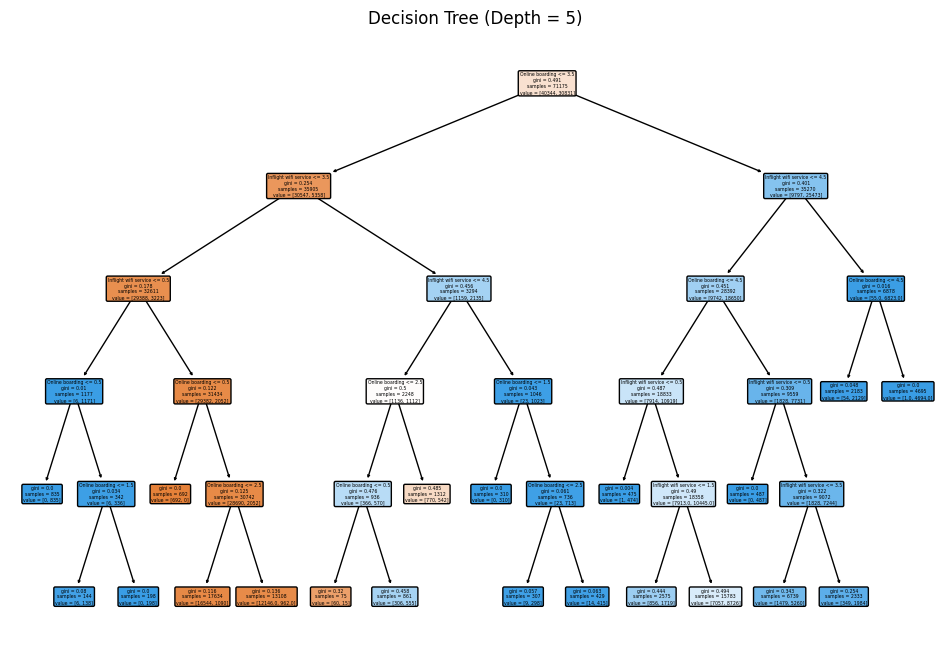

In [169]:
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_depth_5, feature_names=selected_features, filled=True, rounded=True)
plt.title('Decision Tree (Depth = 5)')
plt.show()

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [173]:
%pip install graphviz
%pip install pydotplus

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [174]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    decision_tree_depth_5, 
    out_file=None, 
    feature_names=selected_features, 
    class_names=['Not Satisfied', 'Satisfied'],
    filled=True, 
    rounded=True, 
    special_characters=True
)

graph = graphviz.Source(dot_data)  
graph.render("decision_tree") 
graph 

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

`Ваш ответ здесь. `

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

Построил выше

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

In [ ]:
# Ваш код здесь

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


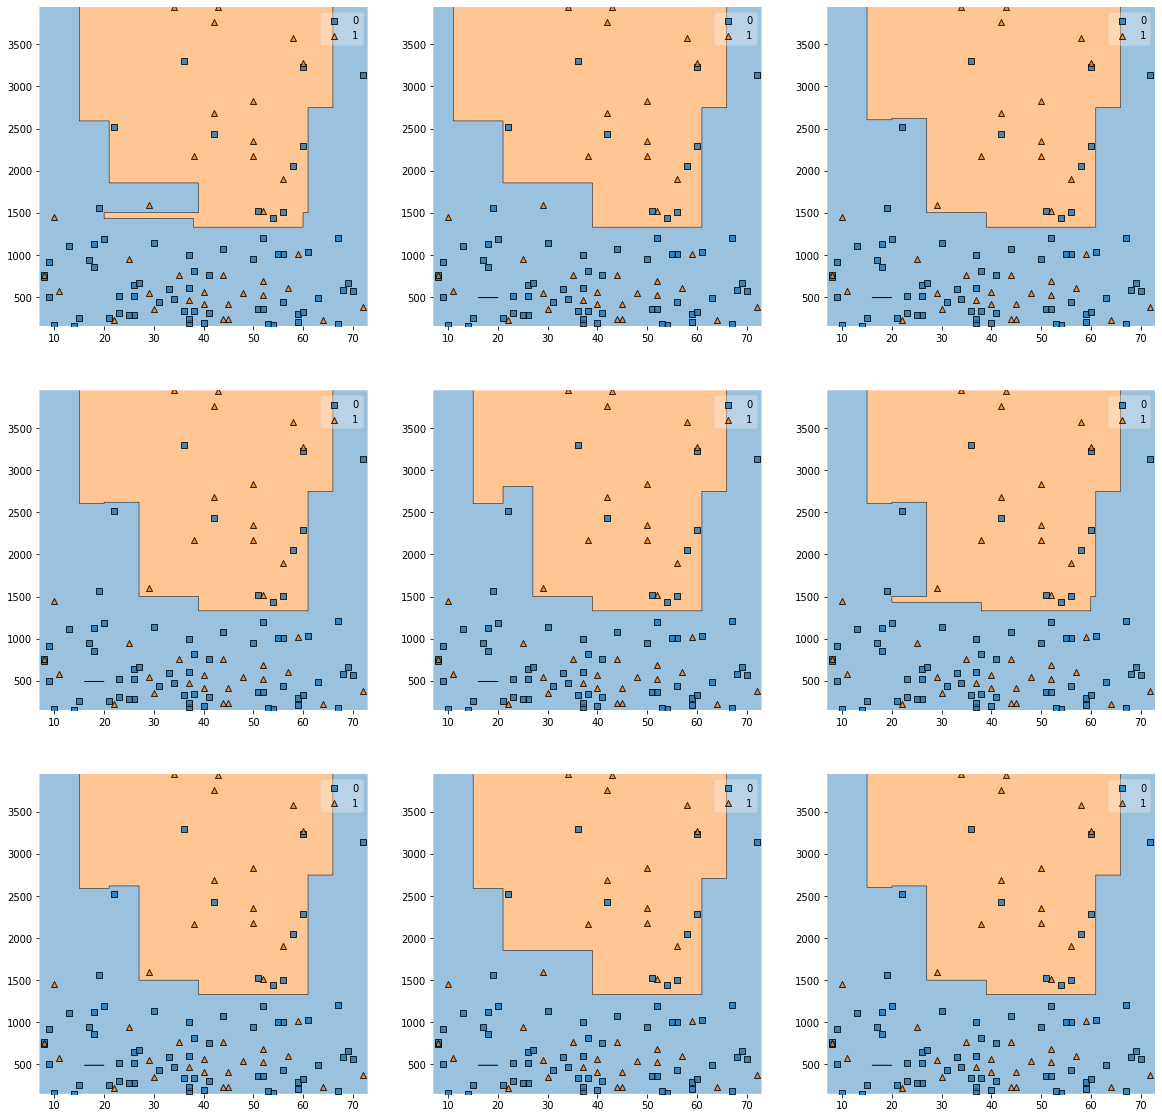

In [ ]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

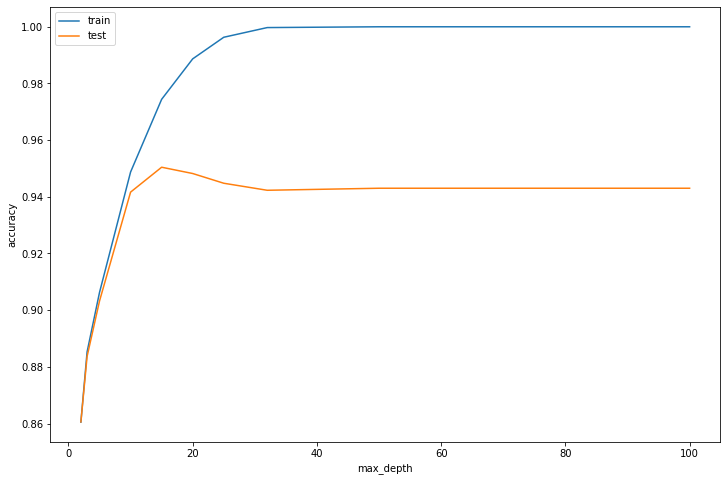

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
# you know what to do



### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
# Ваш код здесь



### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

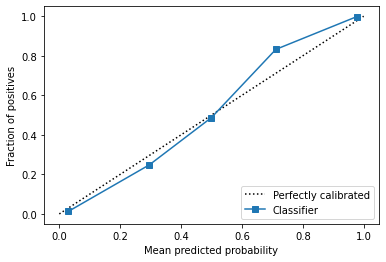

In [ ]:
# Ваш код здесь



Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Ваш ответ здесь
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

CPU times: user 530 ms, sys: 278 ms, total: 808 ms
Wall time: 431 ms


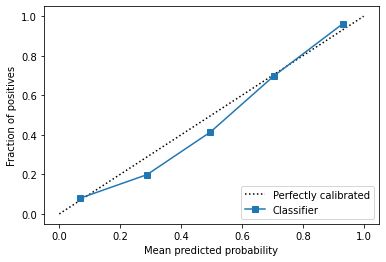

In [ ]:
# Ваш код здесь

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Ваш ответ здесь
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
# Ваш код здесь

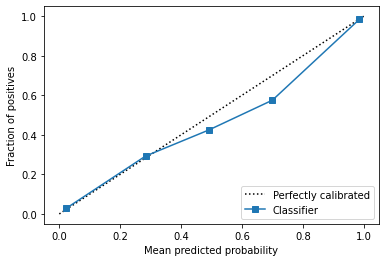

In [ ]:
# Ваш код здесь (Logreg)

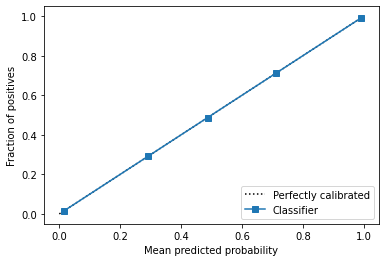

In [ ]:
# Ваш код здесь (isoreg)

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Ваш ответ здесь
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
# Ваш код здесь


```
Ваш ответ здесь
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
# Ваш код здесь


### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# Ваш код здесь


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


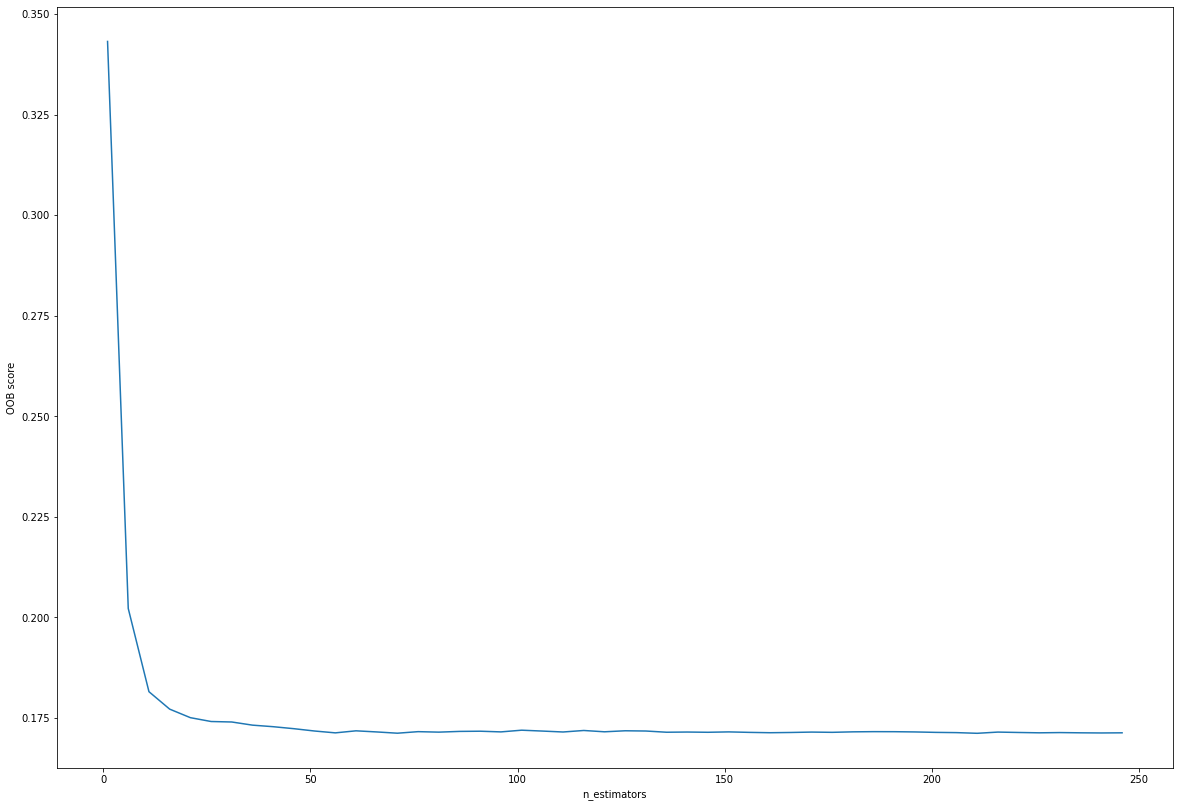

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

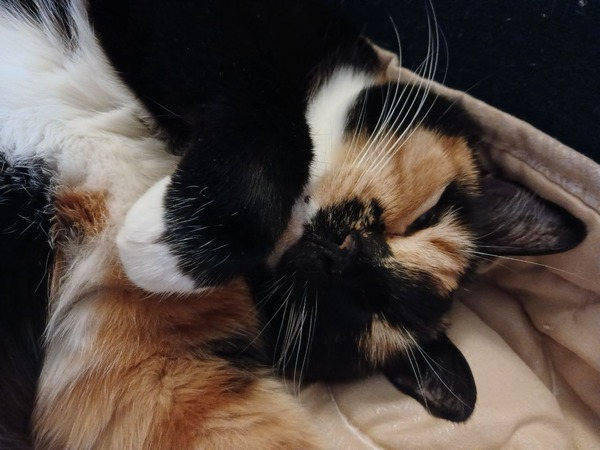

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?